# Laboratorium 3

## Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
from matplotlib.widgets import Button
import json as js
from rb_tree import RBNode, RBTree
import random
import heapq
import copy


class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


## Rozwiązanie

### Struktury i generowanie zbioru odcinków

In [2]:
class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.segment = None
        self.type = None

    def add_segment(self, segment, t):
        self.segment = segment
        self.type = t

    def intersection(self, s1, s2):
        self.type = 'i'
        self.segment = (s1, s2)

    def __str__(self):
        return '('+str(self.x)+', '+str(self.y)+')'
    
    def __repr__(self):
        return '('+str(self.x)+', '+str(self.y)+')\n'

    def __lt__(self, other):
        return self.x < other.x or (self.x == other.x and self.type == 'b' and not other.type == 'e') and (self.x == other.x and self.y < other.y)

    def __eq__(self, other):
        eps = 10**(-6)
        return abs(self.x-other.x)<eps and abs(self.y-other.y)<eps

    def __hash__(self):
        return 31*hash(round(self.x, 6)) + 17*hash(round(self.y, 6))

def det(a, b, c):
    return ((b.y-a.y)*(c.x-a.x)-(c.y-a.y)*(b.x-a.x))

def orientation_rel_to_line(point, segment, eps=1e-6):
    orient = det(segment.b, segment.e, point)
    #print(orient)
    if(orient > eps):
        return 1
    elif(orient < -eps):
        return -1
    else:
        return 0

class Segment():
    def __init__(self, b, e):
        self.b = b
        self.e = e
        self.op = b
        b.add_segment(self, 'b')
        e.add_segment(self, 'e')

    def change_op(self, p):
        self.op = p

    def __lt__(self, other):
        orient = None
        if self.op.x >= other.op.x:
            orient = orientation_rel_to_line(self.op, other)
        else:
            orient = -orientation_rel_to_line(other.op, self)
            
        return (orient == 1) or (orient == 0 and orientation_rel_to_line(self.e, other) == 1)

    def __str__(self):
        return '['+str(self.b)+', '+str(self.e)+']'

    def __repr__(self):
        return '['+str(self.b)+', '+str(self.e)+']\n'


def common_ends(segments, p):
    for segment in segments:
        if segment.b == p or segment.e == p:
            return True        
    return False

def transform(segment):
    return [(segment.b.x, segment.b.y), (segment.e.x, segment.e.y)]

def generate_random(n, x1, x2, y1, y2):
    r = random.uniform
    segments = []
    
    for i in range(n):
        p1 = Point(0,0)
        p2 = Point(0,0)
        while p1.x==p2.x:
            p1 = Point(r(x1, x2), r(y1, y2))
            while common_ends(segments, p1):
                p1 = Point(r(x1, x2), r(y1, y2))
                
            p2 = Point(r(p1.x, x2), r(p1.y, y2))
            while common_ends(segments, p2):
                p2 = Point(r(p1.x, x2), r(p1.y, y2))
        s = Segment(p1, p2)
        segments.append(s)
    return segments

def file_to_data(filename):
    segments = []
    with open(filename) as json_file:
        data = json.load(json_file)
        #print(data[0]['lines'][0])
        for s in data[0]['lines'][0]:
            if s[0][0] < s[1][0]:
                p1 = Point(s[0][0], s[0][1])
                p2 = Point(s[1][0], s[1][1])
            else:
                p2 = Point(s[0][0], s[0][1])
                p1 = Point(s[1][0], s[1][1])
            seg = Segment(p1, p2)
            segments.append(seg)
            
    return segments

def data_to_file(plot, filename):
    with open(filename, 'w') as file:
        file.write(plot.toJson())


<IPython.core.display.Javascript object>


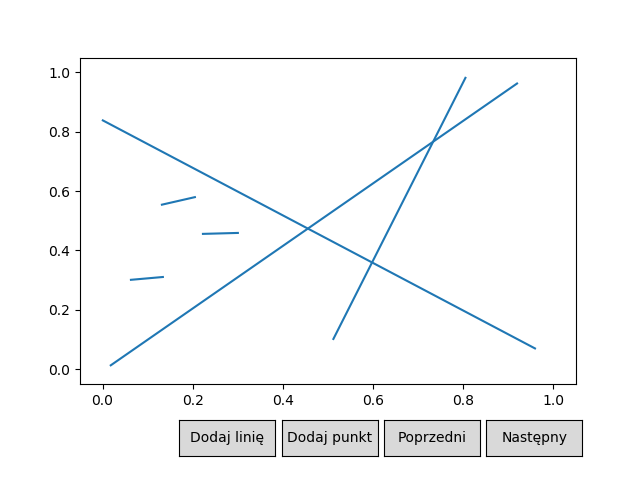

In [3]:
%matplotlib notebook
plot1 = Plot()
plot1.draw()

In [4]:
plot2 = Plot([plot1.get_added_elements()])
data_to_file(plot2, 'data.json')

In [5]:
segments_draw = file_to_data('data.json')

<IPython.core.display.Javascript object>


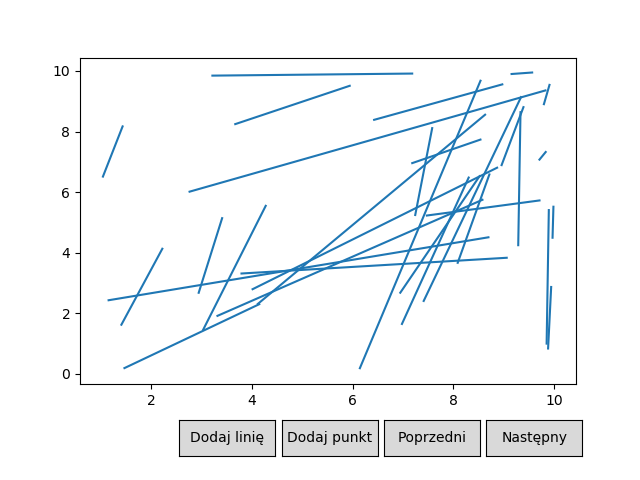

In [6]:
%matplotlib notebook
segments = generate_random(30, 0, 10, 0, 10)
scenes=[Scene([], [LinesCollection([transform(x) for x in segments])])]
plot = Plot(scenes)
data_to_file(plot, 'generated_data.json')
plot.draw() 

### Algorytm zamiatania

In [7]:
def compare(a, b, eps = 10**-6):
    if eps < b.x - a.x:
        return -1
    elif -eps > b.x - a.x:
        return 1
    else:
        if a.begin and not b.begin:
            return -1
        elif not a.begin and b.begin:
            return 1
        else:
            if eps <b.y - a.y:
                return -1
            else:
                return 1

def on_segment(a_begin, a_end, P):
    return det(a_begin, a_end, P)==0 and min(a_begin.x, a_end.x)<=P.x<=max(a_begin.x, a_end.x) and min(a_begin.y, a_end.y)<=P.y<=max(a_begin.y, a_end.y)

def inter_exist(a_b, a_e, b_b, b_e):
    if a_b==b_b or a_e==b_b:
        return False
    
    #check colinearity
    if on_segment(a_b, a_e, b_b) or on_segment(a_b, a_e, b_e) or on_segment(b_b, b_e, a_b) or on_segment(b_b,b_e, a_e):
        return True
    
    d1 = det(a_b, a_e, b_b)
    d2 = det(a_b, a_e, b_e)
    d3 = det(b_b, b_e, a_b)
    d4 = det(b_b, b_e, a_e)

    
    return ((d1<0 and d2>0) or (d1>0 and d2<0)) and ((d3<0 and d4>0) or (d3>0 and d4<0))  
    

def int_p(s1, s2, eps= 10**(-6)):
    r = (s1.e.x-s1.b.x, s1.e.y-s1.b.y)
    s = (s2.e.x-s2.b.x, s2.e.y-s2.b.y)
    
    rs = r[0]*s[1] - r[1]*s[0]
    
    if rs>eps or rs<-eps:
        q = (s2.b.x - s1.b.x, s2.b.y - s1.b.y)
        t = (q[0]*s[1]-q[1]*s[0]) / rs
        u = (q[0]*r[1]-q[1]*r[0]) / rs
        
        if t<=1.0 and t>=0.0 and u<=1.0 and u>=0.0:
            p = Point(s1.b.x + t*r[0], s1.b.y + t*r[1])
            p.intersection(s1, s2)
            return p
    return None


def get_segment_points(segments):
    points = []
    for s in segments:
        points.append(s.b)
        points.append(s.e)
    return points

def vertical_on_point(point, y1, y2):
    return [(point.x, y1), (point.x, y2)]

def transform_points(p):
    return (p.x, p.y)

def check_neighbours(broom, pq, s0, s1, intersecting_segments, inter_points):
    pred=broom.predecessor(s0)
    if pred and inter_exist(pred.b, pred.e, s0.b, s0.e):
        intersecting_segments.append((pred, s0))
        i = int_p(pred, s0)
        if i and not(i in inter_points):
            heapq.heappush(pq, i)
            inter_points.add(i)

    succ = broom.successor(s1)
    if succ and inter_exist(succ.b, succ.e, s1.b, s1.e):
        #print("in")
        intersecting_segments.append((succ, s1))
        i = int_p(succ, s1)
        #print(i)
        if i and not(i in inter_points):
            heapq.heappush(pq, i)
            inter_points.add(i)
            
def get_max_y(segments):
    y = segments[0].b.y
    for s in segments:
        if s.b.y>y:
            y = s.b.y
        if s.e.y>y:
            y = s.e.y
    return y

def get_min_y(segments):
    y = segments[0].b.y
    for s in segments:
        if s.b.y<y:
            y = s.b.y
        if s.e.y<y:
            y = s.e.y
    return y

def intersection_points_visualize(segments):
    y1 = get_min_y(segments)
    y2 = get_max_y(segments)
    points = get_segment_points(segments)  
    
    sc = []
    sc.append(Scene([], [LinesCollection([transform(x) for x in segments])]))
    
    pq = []
    for p in points:
        heapq.heappush(pq, p)
        
    broom = RBTree()
    intersecting_segments = []
    inter_points = set()
    b_state = []
    ind = 0
    while pq:
        #print(inter_points)
        point = heapq.heappop(pq)

        sc.append(Scene([PointsCollection([transform_points(x) for x in inter_points])],
              [LinesCollection([transform(x) for x in segments]),
               LinesCollection([vertical_on_point(point, y1, y2)], color='green')]))
        

        if point.type=='i':
            tr = broom.nodes()
            broom.remove(point.segment[0])
            broom.remove(point.segment[1])
            point.segment[0].change_op(point)
            point.segment[1].change_op(point)
            broom.insert(point.segment[0])
            broom.insert(point.segment[1])
            tr = broom.nodes()
            if point.segment[0]>point.segment[1]:
                check_neighbours(broom, pq, point.segment[1], point.segment[0], intersecting_segments, inter_points)
            else:
                check_neighbours(broom, pq, point.segment[0], point.segment[1], intersecting_segments, inter_points)

        elif point.type=='b':
            s = point.segment
            broom.insert(s)
            pred = broom.predecessor(s)
            succ = broom.successor(s)
            i = int_p
            if pred and inter_exist(pred.b, pred.e, s.b, s.e):
                intersecting_segments.append((pred, s))
                i = int_p(pred, s)
                if i and not(i in inter_points):
                    heapq.heappush(pq, i)
                    inter_points.add(i)
            if succ and inter_exist(succ.b, succ.e, s.b, s.e):
                intersecting_segments.append((succ, s))
                i = int_p(succ, s)
                if i and not (i in inter_points):
                    heapq.heappush(pq, i)
                    inter_points.add(i)
        else:
            s = point.segment
            pred = broom.predecessor(s)
            succ = broom.successor(s)
            broom.remove(s)
            if pred and succ and (inter_exist(pred.b, pred.e, succ.b, succ.e)):
                intersecting_segments.append((pred, succ))
                i = int_p(pred, succ)
                if i and not (i in inter_points):
                    heapq.heappush(pq, i)
                    inter_points.add(i)
           
    return (len(inter_points), intersecting_segments, inter_points, sc, b_state)


<IPython.core.display.Javascript object>


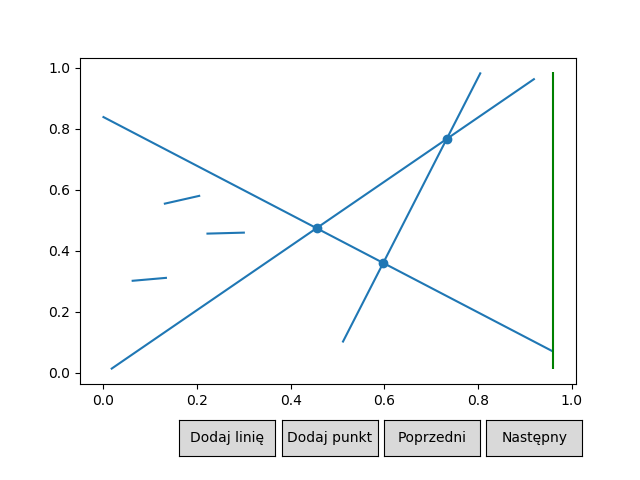

In [8]:
%matplotlib notebook
s = copy.deepcopy(segments_draw)
(n, i_segments, i_points, scenes, b_state) = intersection_points_visualize(s)
plot = Plot(scenes)
plot.draw()